# About this notebook

This notebook analyzes the data update in the Novozymes Enzyme Stability Prediction competition. The data update was introduced with the following post:
https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251

In this notebook, I focus on why such an update was needed. The reasoning provided in the post was that there were data quality issues in the replaced rows and some pH and tm values were transposed. So, was it really the case and how important is it? Let's dig in.

In [1]:
# The usual imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


In [2]:
train_file_path = '/kaggle/input/novozymes-enzyme-stability-prediction/train.csv'
df = pd.read_csv(train_file_path)
df = df.set_index('seq_id', drop=False)
df_without_source = df[df.data_source.isnull( )]
df_from_reliable_sources = df.dropna(subset=['data_source'])

## Getting familiar with data

The dataframe has 31390 rows. About 1/10th of it(3347) are no-source data as shown below.

In [3]:
display(df.info())
display(df_without_source.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3347 entries, 69 to 30742
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            3347 non-null   int64  
 1   protein_sequence  3347 non-null   object 
 2   pH                3335 non-null   float64
 3   data_source       0 non-null      object 
 4   tm                3347 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 156.9+ KB


None

# Problems with no-source data

Here I list the suspicies attributes of no-source data.

## 1) It includes invalid pH values. 
No other sources have this type of error. Below, both df_without_source and df are listed with their highest pH values and number of their occurances. The numbers are the same for all invalid pH values, meaning that the invalid pH values are only coming from no-source data.

In [4]:
display(df_without_source.groupby(['pH']).count().tail(8))
display(df.groupby(['pH']).count().tail(8))

,seq_id,protein_sequence,data_source,tm
pH,,,,
10.3,1,1,0,1
11.0,5,5,0,5
39.0,1,1,0,1
48.4,12,12,0,12
49.0,5,5,0,5
53.4,4,4,0,4
55.6,5,5,0,5
64.9,2,2,0,2


,seq_id,protein_sequence,data_source,tm
pH,,,,
10.4,6,6,6,6
11.0,27,27,22,27
39.0,1,1,0,1
48.4,12,12,0,12
49.0,5,5,0,5
53.4,4,4,0,4
55.6,5,5,0,5
64.9,2,2,0,2


## 2) No-source data has too many edge cases
The previous example already showed high occurance of high pH values. Below another high occurance can be observed for low tm values. Although only 1/10 of the data is no-source data, most of low tm data are also no-source. This is too much for an unreliable source.

In [5]:
low_tm = df[df['tm'] < 5]
low_tm.head(10)

,seq_id,protein_sequence,pH,data_source,tm
seq_id,,,,,
6022,6022,MARRPRHSIYSSDEDDEDIEMCDHDYDGLLPKSGKRHLGKTRWTRE...,7.5,10.1006/jmbi.1999.3099,2.8
9854,9854,MERYENLFAQLNDRREGAFVPFVTLGDPGIEQSLKIIDTLIDAGAD...,7.8,NaN,4.0
13447,13447,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...,64.9,NaN,0.2
13449,13449,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...,64.9,NaN,0.1
14640,14640,MKMSRLCLSVALLVLLGTLAASTPGCDTSNQAKAQRPDFCLEPPYT...,39.0,NaN,0.0
18007,18007,MMYSKLLTLTTLLLPTALALPSLVERACDYTCGSNCYSSSDVSTAQ...,4.8,NaN,0.0
18008,18008,MMYSKLLTLTTLLLPTALALPSLVERACDYTCGSNCYSSSDVSTAQ...,4.8,NaN,0.0
18010,18010,MMYSKLLTLTTLLLPTALALPSLVERACDYTCGSNCYSSSDVSTAQ...,4.8,NaN,0.0
18856,18856,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.2,NaN,-1.0


## 3) No-source data has significantly different distribution compare to the rest 
To do this analysis, I removed pH=7 data from both dataframes, since both of them have mostly pH=7 rows and it prevents doing analysis on the rest. I also removed ph>14 from no-source data, since those rows are already invalid.
Below we can see that most of the ph!=7 data has tm around 60 and there is a gaussian-like distribution. For no-source data, most of the tm is around 25 without any proper looking distribution.

array([[<AxesSubplot:title={'center':'seq_id'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'tm'}>, <AxesSubplot:>]],
      dtype=object)

array([[<AxesSubplot:title={'center':'seq_id'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'tm'}>, <AxesSubplot:>]],
      dtype=object)

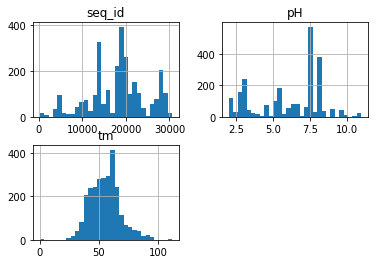

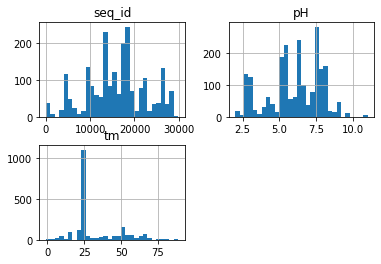

In [6]:
df_from_reliable_sources_wo_ph_7 = df_from_reliable_sources.drop(df_from_reliable_sources[df_from_reliable_sources.pH == 7].index)
display(df_from_reliable_sources_wo_ph_7.hist(bins = 30))

df_without_source_wo_extreme_pH = df_without_source.drop(df_without_source[df_without_source.pH > 14].index)
df_without_source_wo_extreme_pH_wo_7 = df_without_source_wo_extreme_pH.drop(df_without_source_wo_extreme_pH[df_without_source_wo_extreme_pH.pH == 7].index)
display(df_without_source_wo_extreme_pH_wo_7.hist(bins = 30))

# Competition data update

In the previous section, I found some weird abnormal attributes of no-source data. Now I will briefly check how much of that data is changed by the data update provided by competition.
First graph shows the similarity of sequnce id distributions of no-source data and the data update. Later, we see that among 2434 data rows that are updated, 2392 of them were part of no-source data that we evaluated in previous section (in line with what was announced by competition). However, there still remains some no-source data that is not changed and the reliability of that shall also be evaluated (not a part of this notebook).

<AxesSubplot:>

<AxesSubplot:>

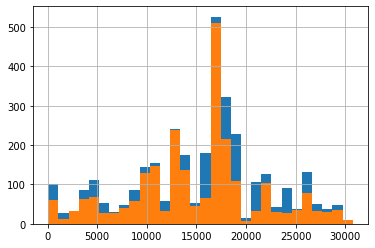

In [7]:
display(df_without_source.seq_id.hist(bins = 30))

train_file_path_update = '/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv'
df_update = pd.read_csv(train_file_path_update)
df_update = df_update.set_index('seq_id', drop=False)

display(df_update.seq_id.hist(bins = 30))

In [8]:
display(df_update.info())
display(df_without_source.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 69 to 30742
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            2434 non-null   int64  
 1   protein_sequence  25 non-null     object 
 2   pH                25 non-null     float64
 3   data_source       0 non-null      float64
 4   tm                25 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 114.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3347 entries, 69 to 30742
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            3347 non-null   int64  
 1   protein_sequence  3347 non-null   object 
 2   pH                3335 non-null   float64
 3   data_source       0 non-null      object 
 4   tm                3347 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 285.9+ KB


None

In [9]:
df_update.seq_id.isin(df_without_source.seq_id).value_counts()

True     2392
False      42
Name: seq_id, dtype: int64

# Conclusion

This notebook analyzes the data update in the Novozymes Enzyme Stability Prediction competition and the underlying reasons. Some problems about the no-source data is pointed. Shortly, no-source data had some invalid pH values, too many edge cases, and significantly different distribution compare to the rest of the data. Of course, it can still be argued that these different distributions and edge cases provide a more in depth understanding of possible edge case scenarios. However, if the data does not have a source(unlike others) and if it behaves significantly different than the rest, it will always stay suspicious. So in the end, most of it is removed from the competition.

This was interesting for me to check since it is my first competition. Hope you find it useful. Thanks for reading.